In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

train = pd.read_excel("/data/p_dsi/teams2023/team1/apple/apple_train_data_final.xlsx")
test = pd.read_excel("/data/p_dsi/teams2023/team1/apple/apple_test_data_final.xlsx")
# test = pd.read_excel("/Users/yahan/Downloads/apple_test_data_final.xlsx")
# train = pd.read_excel("/Users/yahan/Downloads/apple_train_data_final.xlsx")
# merge the two dataframes
train['train'] = 1
test['train'] = 0
orig_data = pd.concat([train, test], axis=0).drop(['phone model', 'day'], axis=1)
orig_data.loc[orig_data.index.isin(['2022-12-19', '2022-12-26']), 'train'] = 1
orig_data.head()

,phone size,phone color,claim,weeks_monday,generation,week_of_month,month,year,weeks_since_release,is_holiday,train
0,128,black,111,2021-06-28,11,4,6,2021,92.428571,1,1
1,128,black,319,2021-07-05,11,1,7,2021,93.428571,1,1
2,128,black,320,2021-07-12,11,2,7,2021,94.428571,1,1
3,128,black,305,2021-07-19,11,3,7,2021,95.428571,1,1
4,128,black,269,2021-07-26,11,4,7,2021,96.428571,1,1


### functions

In [7]:
def wmape(actual, forecast):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE) with equal weights"""
 
    numerator = np.sum(np.abs(actual - forecast)) * 100
    denominator = np.sum(np.abs(actual))

    return numerator/denominator

## calculate the diffence of ts 
def diff_ts(ts, lag=1):
    """Calculate the difference of a time series with a lag"""
    return ts - ts.shift(lag)

## set the weights for different models
# the other models should all be 0.3
def get_model_weight(generation, model_weights={'13':1, '12':0.9, '14':0.9, '11':0.7, 'other':0.3}):
    if generation in model_weights:
        return model_weights[generation]
    else:
        return model_weights['other']
    
## check if the data with date is stationary using Augmented Dickey-Fuller test
def adf_test(ts, lag=1):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary")
    # return ts + ts.shift(lag)

# plot the claim for each phone size 
def plot_ip14_claim_pred(plot_df, title = 'training data : add 2 weeks data', grouping = False):
    fig, ax = plt.subplots(figsize=(10, 5))

    if grouping == False:
        color_dict = {128: 'red', 256: 'blue', 512: 'green'}
        for size in plot_df['phone size'].unique():
            color = color_dict[size]
            ax.plot(plot_df.loc[plot_df['phone size'] == size, 'claim'], color=color,label=size)
            ax.plot(plot_df.loc[plot_df['phone size'] == size, 'pred'], color=color, linestyle='--', label=size)
    else:
        ax.plot(plot_df['claim'], label='actual')
        ax.plot(plot_df['pred'], linestyle='--', label='pred')

    ax.set_title('iphone 14 claim')
    ax.set_xlabel('weeks since release')
    ax.set_ylabel('claim')
    ax.legend()
    ax.set_title(title)

    plt.show()

## print the rmse and test wmape. if show_train set to Ture, the train wmape will be print.
def print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=False):
    print("test WMAPE: {:.2f}%".format(wmape(y_test, y_pred)))
    if show_train:
        print("train WMAPE: {:.2f}%".format(wmape(y_train, y_train_fit)))
    #calculate the rmse
    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('rmse:', round(rmse, 3))

## the GB model for predicting each size iphone 14 claims

### add diff
in this part we will loss 53 data points and there are 17 models. for each model, the data points we will loss is the same amount of phone size such model has.


In [11]:
# group by weeks_monday and generation, but keep all other columns, including week_of_month, month, year, weeks_since_release, is_holiday, day, train
agg_dat = orig_data.groupby(['weeks_monday', 'generation', 'phone size']).agg({'week_of_month': 'first', 'year': 'first', 'month': 'first', 'weeks_since_release': 'first', 'is_holiday': 'first', 'train': 'first', 'claim': 'sum'}).reset_index().set_index('weeks_monday')

count_na = 0
diff_dat = agg_dat.copy()
for gene in diff_dat['generation'].unique():
    tep = diff_dat.loc[diff_dat['generation']==gene]
    for size in tep['phone size'].unique():
        diff_dat.loc[(diff_dat['generation']==gene) & (diff_dat['phone size']==size), 'diff_claim'] = diff_ts(tep.loc[tep['phone size']==size, 'claim'])
        count_na += 1
    

print(diff_dat.shape, diff_dat.dropna().shape)
print(count_na)
diff_dat_nonan = diff_dat.dropna()
diff_dat_nonan.head()

(3254, 10) (3201, 10)
53


,generation,phone size,week_of_month,year,month,weeks_since_release,is_holiday,train,claim,diff_claim
weeks_monday,,,,,,,,,,
2021-07-05,11,64,1,2021,7,93.428571,1,1,2054,1268.0
2021-07-05,11,128,1,2021,7,93.428571,1,1,743,468.0
2021-07-05,11,256,1,2021,7,93.428571,1,1,1185,779.0
2021-07-05,11,512,1,2021,7,93.428571,1,1,86,54.0
2021-07-05,12,128,1,2021,7,33.428571,1,1,583,327.0


We examined the data that we care about the most, and found that all of them became stationary after applying first-order differencing.

In [12]:
# check if the data with date is stationary using Augmented Dickey-Fuller test
adf_test(diff_dat_nonan.loc[(diff_dat_nonan['generation']=='12')&(diff_dat_nonan['phone size']==128), 'diff_claim'])
diff_dat_nonan.index = pd.to_datetime(diff_dat_nonan.index)

ADF Statistic: -8.978937
p-value: 0.000000
Critical Values:
	1%: -3.510
	5%: -2.896
	10%: -2.585
Reject the null hypothesis. Data is stationary


### split train and test

In [13]:
exp_dat = diff_dat_nonan.copy()
exp_dat = pd.get_dummies(exp_dat, columns=['generation'])

train = exp_dat[exp_dat['train'] == 1].drop(['train'], axis=1)
test = exp_dat[exp_dat['train'] == 0].drop(['train'], axis=1)

x_train = train.drop(['claim'], axis=1)
y_train = train['claim']

x_test = test.drop(['claim'], axis=1)
y_test = test['claim']

train.shape, test.shape

((2782, 25), (419, 25))

## modeling
loss='absolute_error', subsample=0.5, max_depth = 5, n_estimators = 125, learning_rate=0.081, random_state=42

model_weights={'13':1, '12':0.9, '14':0.9, '11':0.7, 'other':0.3}

test WMAPE: 33.07%
train WMAPE: 19.29%
rmse: 237.542
iphone 14 WMAPE: 78.87%


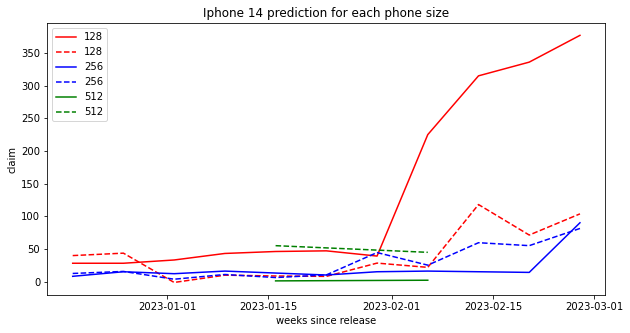

In [14]:
## the model minimizes the overall wmape
## the model minimizes the wmape for iphone 14
model = GradientBoostingRegressor(loss='absolute_error', subsample=0.5, max_depth = 5, n_estimators = 125, learning_rate=0.081, random_state=42)

# set weights
temp = diff_dat_nonan.copy()
gener_weights = temp.loc[temp['train']==1, 'generation'].apply(get_model_weight)

# Fit the model to the training data with custom sample weights
model.fit(x_train, y_train, sample_weight=gener_weights)
y_pred = model.predict(x_test)
y_train_fit = model.predict(x_train)

print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=True)

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)

plot_ip14_claim_pred(plot_df, title = 'Iphone 14 prediction for each phone size')

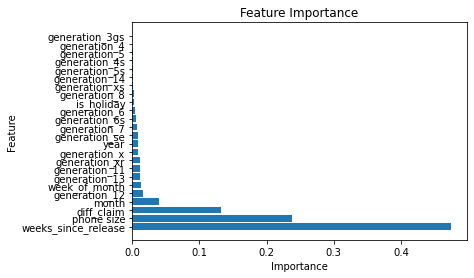

In [20]:
# Get the feature importance scores
importances = model.feature_importances_

# Sort the features by descending order of importance
sorted_idx = importances.argsort()[::-1]
feature_names = x_train.columns[sorted_idx]

# Create a bar plot of feature importances
fig, ax = plt.subplots()
ax.barh(feature_names, importances[sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
plt.show()

## the GB model for predicting over all iphone 14 claims

loss='absolute_error', subsample=0.4, max_depth = 7, n_estimators = 105, learning_rate=0.035, random_state=42

custom_weights = {'13':.9, '12':.8, '14':.85, '11':0.6, 'other':.3}

In [21]:
# aggreate the data by weeks_monday and generation, but keep all other columns, including week_of_month	month	year	weeks_since_release	is_holiday	day	train
all_agg_dat = orig_data.groupby(['weeks_monday', 'generation']).agg({'week_of_month': 'first', 'year': 'first', 'month': 'first', 'weeks_since_release': 'first', 'is_holiday': 'first', 'train': 'first', 'claim': 'sum'}).reset_index().set_index('weeks_monday')

# calculate the difference of claim
count_na = 0
all_diff_dat = all_agg_dat.copy()
for gene in diff_dat['generation'].unique():
    all_diff_dat.loc[all_diff_dat['generation']==gene, 'diff_claim'] = diff_ts(all_diff_dat.loc[all_diff_dat['generation']==gene, 'claim'])
    count_na += 1
# print(all_diff_dat.shape, all_diff_dat.dropna().shape)
# print(count_na)
all_diff_nonan = all_diff_dat.dropna()
# all_diff_nonan.head()

exp_dat = all_diff_nonan.copy()
exp_dat = pd.get_dummies(exp_dat, columns=['generation'])

train = exp_dat[exp_dat['train'] == 1].drop(['train'], axis=1)
test = exp_dat[exp_dat['train'] == 0].drop(['train'], axis=1)

x_train = train.drop(['claim'], axis=1)
y_train = train['claim']

x_test = test.drop(['claim'], axis=1)
y_test = test['claim']

train.shape, test.shape

((972, 24), (147, 24))

test WMAPE: 33.24%
train WMAPE: 7.07%
rmse: 586.751
iphone 14 WMAPE: 54.02%


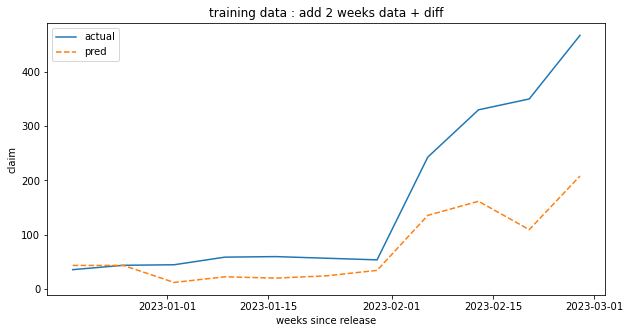

In [22]:
## the model minimizes the overall wmape
# model = GradientBoostingRegressor(loss='huber', subsample=0.7, max_depth = 6, n_estimators = 105, learning_rate=0.096, random_state=42)
## the model minimizes the wmape for iphone 14
model = GradientBoostingRegressor(loss='absolute_error', subsample=0.4, max_depth = 7, n_estimators = 105, 
                                  learning_rate=0.035, random_state=42)

# set weights
temp = all_diff_nonan.copy()
custom_weights = {'13':.9, '12':.8, '14':.85, '11':0.6, 'other':.3}
gener_weights = temp.loc[temp['train']==1, 'generation'].apply(lambda x: get_model_weight(x, custom_weights))

# Fit the model to the training data with custom sample weights
model.fit(x_train, y_train, gener_weights)
y_pred = model.predict(x_test)
y_train_fit = model.predict(x_train)

print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=True)

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)
plot_df

plot_ip14_claim_pred(plot_df, title = 'training data : add 2 weeks data + diff', grouping=True)

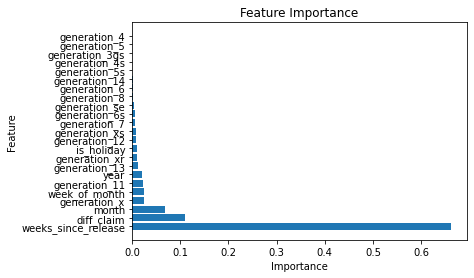

In [23]:
# Get the feature importance scores
importances = model.feature_importances_

# Sort the features by descending order of importance
sorted_idx = importances.argsort()[::-1]
feature_names = x_train.columns[sorted_idx]

# Create a bar plot of feature importances
fig, ax = plt.subplots()
ax.barh(feature_names, importances[sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
plt.show()

### parameter tuning on ip14 wmape

best learning_rate: 0.081
best n_estimators: 125
best max_depth: 5
best subsample: 0.49999999999999994


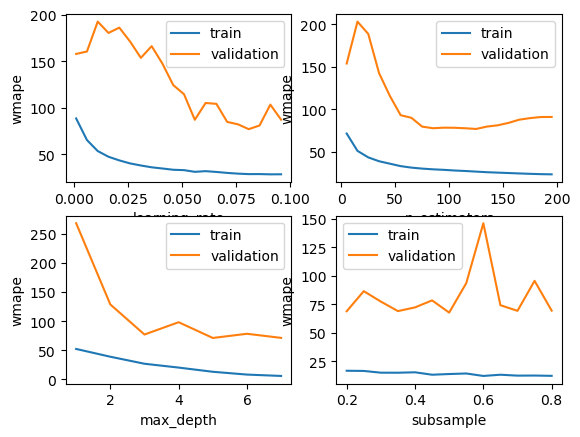

In [165]:
learning_rate = np.arange(.001, 0.1, .005)
n_estimators = np.arange(5, 200, 10)
max_depth = np.arange(1, 8, 1)
subsample = np.arange(.2, .8, .05)
best_lr = min(learning_rate)
best_ne = min(n_estimators)
best_md = min(max_depth)
best_ss = min(subsample)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2)

train_wmape,  vali_wmape = [], []
for lr in learning_rate:
    model = GradientBoostingRegressor(loss = "huber", learning_rate=lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_lr = lr

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)
    
print('best learning_rate:', best_lr)
# Plot the train_wmape and vali_wmape against learning_rate
axs[0, 0].plot(learning_rate, train_wmape, label='train')
axs[0, 0].plot(learning_rate, vali_wmape, label='validation')
axs[0, 0].set_xlabel('learning_rate')
axs[0, 0].set_ylabel('wmape')
axs[0, 0].legend()


train_wmape,  vali_wmape = [], []
for n in n_estimators:
    model = GradientBoostingRegressor(loss = "huber", n_estimators=n, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ne = n

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best n_estimators:', best_ne)
# Plot the train_wmape and vali_wmape against n_estimators
axs[0, 1].plot(n_estimators, train_wmape, label='train')
axs[0, 1].plot(n_estimators, vali_wmape, label='validation')
axs[0, 1].set_xlabel('n_estimators')
axs[0, 1].set_ylabel('wmape')
axs[0, 1].legend()


train_wmape,  vali_wmape = [], []
for md in max_depth:
    model = GradientBoostingRegressor(loss = "huber", max_depth=md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_md = md

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best max_depth:', best_md)
# Plot the train_wmape and vali_wmape against max_depth
axs[1, 0].plot(max_depth, train_wmape, label='train')
axs[1, 0].plot(max_depth, vali_wmape, label='validation')
axs[1, 0].set_xlabel('max_depth')
axs[1, 0].set_ylabel('wmape')
axs[1, 0].legend()


train_wmape,  vali_wmape = [], []
for ss in subsample:
    model = GradientBoostingRegressor(loss = "huber", subsample=ss, max_depth = best_md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ss = ss

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best subsample:', best_ss)
# Plot the train_wmape and vali_wmape against subsample
axs[1, 1].plot(subsample, train_wmape, label='train')
axs[1, 1].plot(subsample, vali_wmape, label='validation')
axs[1, 1].set_xlabel('subsample')
axs[1, 1].set_ylabel('wmape')
axs[1, 1].legend()

# Display the plot
plt.show()

### parameter tuning on wmape

best learning_rate: 0.096
best n_estimators: 105
best max_depth: 6
best subsample: 0.7


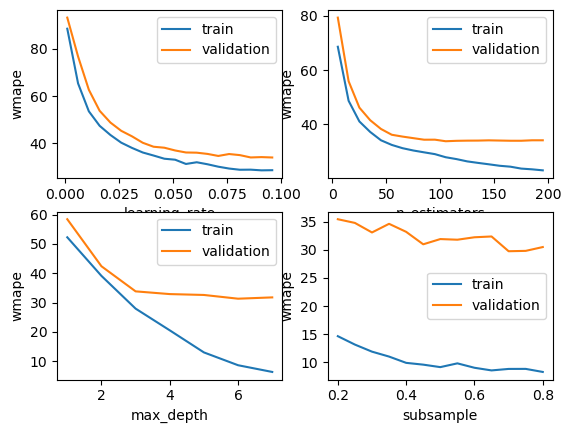

In [163]:
learning_rate = np.arange(.001, 0.1, .005)
n_estimators = np.arange(5, 200, 10)
max_depth = np.arange(1, 8, 1)
subsample = np.arange(.2, .8, .05)
best_lr = min(learning_rate)
best_ne = min(n_estimators)
best_md = min(max_depth)
best_ss = min(subsample)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2)

train_wmape,  vali_wmape = [], []
for lr in learning_rate:
    model = GradientBoostingRegressor(loss = "huber", learning_rate=lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)

    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_lr = lr

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)
    
print('best learning_rate:', best_lr)
# Plot the train_wmape and vali_wmape against learning_rate
axs[0, 0].plot(learning_rate, train_wmape, label='train')
axs[0, 0].plot(learning_rate, vali_wmape, label='validation')
axs[0, 0].set_xlabel('learning_rate')
axs[0, 0].set_ylabel('wmape')
axs[0, 0].legend()


train_wmape,  vali_wmape = [], []
for n in n_estimators:
    model = GradientBoostingRegressor(loss = "huber", n_estimators=n, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ne = n

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best n_estimators:', best_ne)
# Plot the train_wmape and vali_wmape against n_estimators
axs[0, 1].plot(n_estimators, train_wmape, label='train')
axs[0, 1].plot(n_estimators, vali_wmape, label='validation')
axs[0, 1].set_xlabel('n_estimators')
axs[0, 1].set_ylabel('wmape')
axs[0, 1].legend()


train_wmape,  vali_wmape = [], []
for md in max_depth:
    model = GradientBoostingRegressor(loss = "huber", max_depth=md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_md = md

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best max_depth:', best_md)
# Plot the train_wmape and vali_wmape against max_depth
axs[1, 0].plot(max_depth, train_wmape, label='train')
axs[1, 0].plot(max_depth, vali_wmape, label='validation')
axs[1, 0].set_xlabel('max_depth')
axs[1, 0].set_ylabel('wmape')
axs[1, 0].legend()


train_wmape,  vali_wmape = [], []
for ss in subsample:
    model = GradientBoostingRegressor(loss = "huber", subsample=ss, max_depth = best_md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ss = ss

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best subsample:', best_ss)
# Plot the train_wmape and vali_wmape against subsample
axs[1, 1].plot(subsample, train_wmape, label='train')
axs[1, 1].plot(subsample, vali_wmape, label='validation')
axs[1, 1].set_xlabel('subsample')
axs[1, 1].set_ylabel('wmape')
axs[1, 1].legend()

# Display the plot
plt.show()